In [2]:
#https://github.com/caleianderson/CSCA-5622

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay

print("Imports are ok!")

X,y = load_breast_cancer(as_frame=True, return_X_y=True)

#Split the data sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)
print(len(X_train), len(y_train), len(X_test), len(y_test))
print("Data import ok!")



Imports are ok!
455 455 114 114
Data import ok!


In [3]:
df = pd.concat([y_train,X_train], axis=1)
# print(df.columns)
print(df.corr())

                           target  mean radius  mean texture  mean perimeter  \
target                   1.000000    -0.719095     -0.416324       -0.731671   
mean radius             -0.719095     1.000000      0.327140        0.997937   
mean texture            -0.416324     0.327140      1.000000        0.332055   
mean perimeter          -0.731671     0.997937      0.332055        1.000000   
mean area               -0.695293     0.987141      0.323789        0.986479   
mean smoothness         -0.342838     0.140692     -0.047305        0.178371   
mean compactness        -0.572952     0.467114      0.213543        0.518431   
mean concavity          -0.680704     0.655001      0.293815        0.695665   
mean concave points     -0.765935     0.807865      0.281373        0.837924   
mean symmetry           -0.301361     0.110969      0.041655        0.146373   
mean fractal dimension   0.024281    -0.329295     -0.103363       -0.279773   
radius error            -0.557717     0.

Determine what the best combo of factors to predict malignancy is and then train a couple models to attempt to predict malignancy and see which model is the most accurate

In [4]:
model = smf.ols(formula="target ~ Q('mean perimeter') + Q('mean symmetry') + Q('mean smoothness')", data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     224.1
Date:                Sun, 28 Jul 2024   Prob (F-statistic):           5.70e-89
Time:                        17:34:20   Log-Likelihood:                -108.68
No. Observations:                 455   AIC:                             225.4
Df Residuals:                     451   BIC:                             241.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.7827 

In [6]:
#find the accuracy of the linear regression

y_hat = res.predict(X_test)

predictions = []
for i in y_hat:
    if(i > .5):
        predictions.append(1)
    else:
        predictions.append(0)

right = 0
for i in range(len(predictions)):
    if(predictions[i] == y_test.iloc[i]):
        right += 1

if(len(predictions) != len(y_test)):
    print("Something is wrong with the predictions!")

print("Accuracy: ",right/len(predictions))



Accuracy:  0.9298245614035088


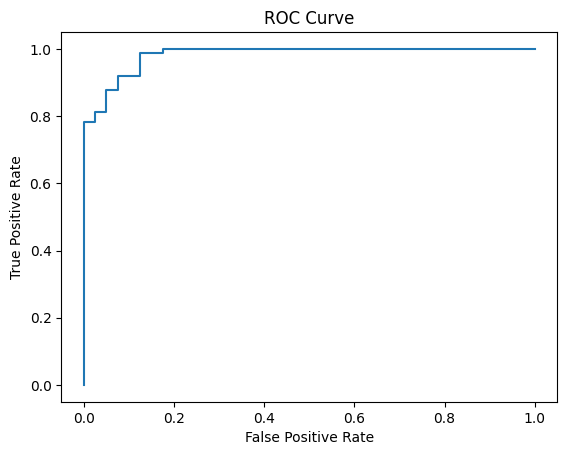

AUC Score:  0.9


In [7]:
fpr, tpr, thresh = roc_curve(y_test, y_hat)

plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

auc = roc_auc_score(y_test, predictions)
print("AUC Score: ",auc)

The highest corrolated values used previously were peimeter and smoothness (slightly beating out symmetry) so now I am going to use those values to create an SVM and see if I can do better then the 85% accuracy from the linear regression.

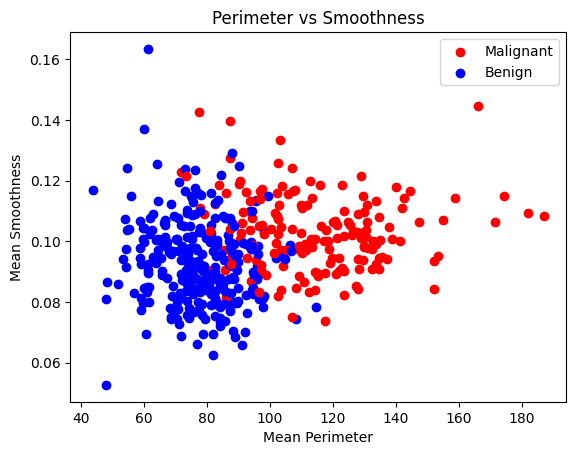

In [2]:
perimiter_train = X_train["mean perimeter"].to_numpy()
smooth_train = X_train["mean smoothness"].to_numpy()
x_arr_train = []
for i in range(len(perimiter_train)):
    x_arr_train.append([perimiter_train[i],smooth_train[i]])

perimiter_test = X_test["mean perimeter"].to_numpy()
smooth_test = X_test["mean smoothness"].to_numpy()
x_arr_test = []
for i in range(len(perimiter_test)):
    x_arr_test.append([perimiter_test[i],smooth_test[i]])



# print(x_arr_train)
x_arr_train = np.array(x_arr_train)
x_arr_test = np.array(x_arr_test)

y_arr_train = y_train.to_numpy()
y_arr_test = y_test.to_numpy()

# graph the points
label1 = 0
label2 =  0
for i in range(len(x_arr_train)):
    # print("point: ",x_arr_train[0], x_arr_train[1])
    if(y_arr_train[i] == 0):
        plt.scatter(x_arr_train[i][0], x_arr_train[i][1], c='red', label="Malignant" if label1 == 0 else "")
        label1 = 1
    else:
        plt.scatter(x_arr_train[i][0], x_arr_train[i][1], c='blue', label="Benign" if label2 == 0 else "")
        label2 = 1

plt.xlabel("Mean Perimeter")
plt.ylabel("Mean Smoothness")
plt.title("Perimeter vs Smoothness")
plt.legend(loc="best")
plt.show()


In [3]:
myrange = range(1, 30)

print("linear")
grid=GridSearchCV(estimator=SVC(), param_grid={'C': myrange, 'gamma': myrange, 'kernel':['linear']}, cv=3) 
grid.fit(x_arr_train,y_arr_train)
print(grid.best_score_)
print(grid.best_params_)

print("\nrbf")
grid=GridSearchCV(estimator=SVC(), param_grid={'C': myrange, 'gamma': myrange, 'kernel':['rbf']}, cv=3) 
grid.fit(x_arr_train,y_arr_train)
print(grid.best_score_)
print(grid.best_params_)

print("\nsigmoid")
grid=GridSearchCV(estimator=SVC(), param_grid={'C': myrange, 'gamma': myrange, 'kernel':['sigmoid']}, cv=3) 
grid.fit(x_arr_train,y_arr_train)
print(grid.best_score_)
print(grid.best_params_)

linear


C:\Users\Cale\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


0.8879981410479841
{'C': 9, 'gamma': 1, 'kernel': 'linear'}

rbf
0.88359765307308
{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

sigmoid
0.630765655861508
{'C': 1, 'gamma': 1, 'kernel': 'sigmoid'}


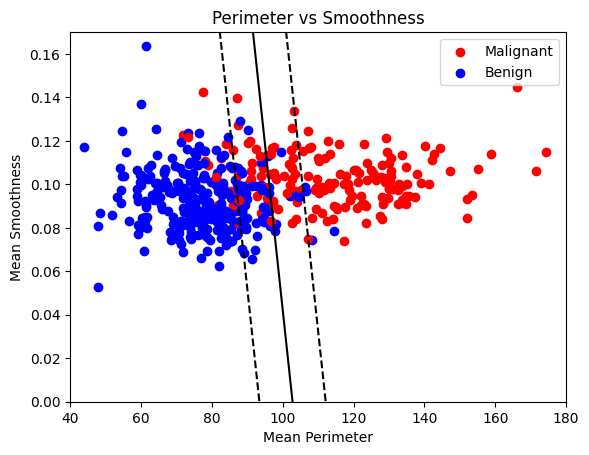

In [9]:
#make a SVC
svc_model= SVC(C=9, gamma=1, kernel = 'linear').fit(x_arr_train,y_arr_train)


        
# graph the svc
label1 = 0
label2 =  0
for i in range(len(x_arr_train)):
    # print("point: ",x_arr_train[0], x_arr_train[1])
    if(y_arr_train[i] == 0):
        plt.scatter(x_arr_train[i][0], x_arr_train[i][1], c='red', label="Malignant" if label1 == 0 else "")
        label1 = 1
    else:
        plt.scatter(x_arr_train[i][0], x_arr_train[i][1], c='blue', label="Benign" if label2 == 0 else "")
        label2 = 1

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
        svc_model,
        x_arr_train,
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        alpha=1,
        linestyles=["--", "-", "--"],
    )



plt.ylim(0,.17)
plt.xlim(40,180)
plt.xlabel("Mean Perimeter")
plt.ylabel("Mean Smoothness")
plt.title("Perimeter vs Smoothness")
plt.legend(loc="best")
plt.show()

In [17]:
#find the accuracy of the linear regression
yhat = svc_model.predict(x_arr_test)

right = 0
for i in range(len(yhat)):
    if(yhat[i] == y_arr_test[i]):
        right += 1

if(len(yhat) != len(y_arr_test)):
    print("Something is wrong with the predictions!")

print("Accuracy: ",right/len(yhat))

Accuracy:  0.8859649122807017
